# Modeling and Simulation in Python

Chapter 8: Pharmacokinetics

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the function defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt|

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
df = pd.read_csv('glucose_insulin.csv', index_col='time')
df

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


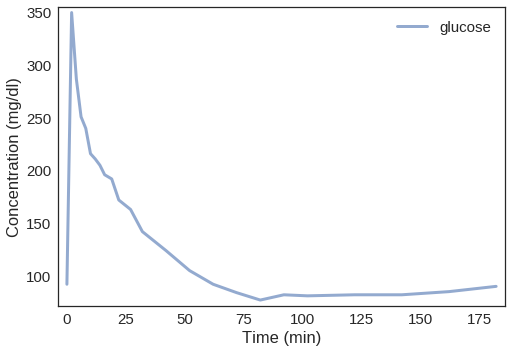

In [3]:
plot(df.glucose, label='glucose')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dl)')

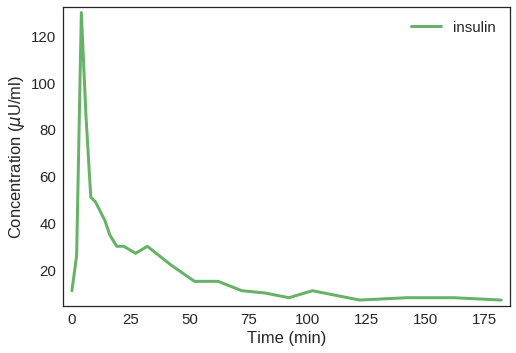

In [4]:
plot(df.insulin, color='green', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/ml)')

Saving figure to file chap08-fig01.pdf


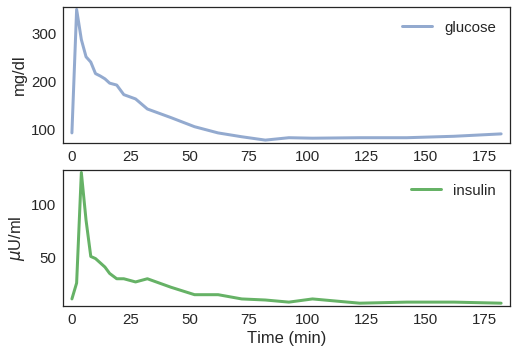

In [5]:
plt.subplot(2, 1, 1)
plot(df.glucose, label='glucose')
decorate(ylabel='mg/dl')

plt.subplot(2, 1, 2)
plot(df.insulin, color='green', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='$\mu$U/ml')

savefig('chap08-fig01.pdf')

In [75]:
print(getsource(interpolate))

def interpolate(series, **options):
    """Creates an interpolation function.

    series: Series object
    options: any legal options to scipy.interpolate.interp1d

    returns: function that maps from the index of the series to its values 
    """
    underride(options, fill_value='extrapolate')
    return interp1d(series.index, series.values, **options)



In [7]:
I = interpolate(df.insulin)

In [8]:
I(18)

array(31.666666666666668)

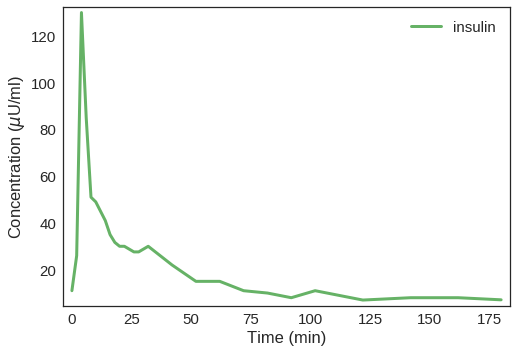

In [9]:
ts = arange(0, 182, 2)
plot(ts, I(ts), color='green', label='insulin')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/ml)')

In [10]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

In [11]:
S_I = k3 / k2
S_I

0.0005

In [12]:
Gb = df.glucose[0]
Ib = df.insulin[0]

In [13]:
init = State(G=G0, X=0)

In [14]:
system = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                t0=0, t_end=182, dt=2)

In [15]:
def update_func(state, t, system):
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [16]:
update_func(init, 0, system)

,value
G,278.12
X,0.00


In [17]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    df = TimeFrame(columns=system.init.index)
    df.loc[t0] = system.init
    
    for t in arange(t0, t_end, dt):
        df.loc[t+dt] = update_func(df.loc[t], t, system)
    
    system.results = df

In [18]:
run_simulation(system, update_func)

In [19]:
system.results

,G,X
0,290,0
2,278.12,0
4,266.953,0.0003
6,256.295,0.002668
8,245.07,0.00404128
10,233.905,0.00467963
12,223.202,0.00525244
14,212.985,0.00572235
16,203.288,0.00609345
18,194.133,0.00632971


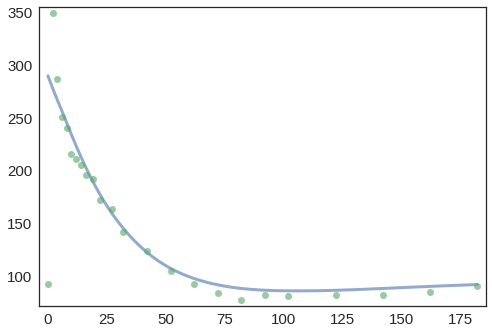

In [20]:
plot(system.results.G)
plot(df.glucose, style='o')

In [21]:
def slope_func(state, t, system):
    G, X = state
    unpack(system)
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

In [22]:
slope_func(init, 0, system)

(-5.9399999999999995, 0.0)

In [29]:
from scipy.integrate import odeint

def run_odeint(system, slope_func):
    """Runs a simulation of the system.
    
    Adds a DataFrame to the System: results
    
    system: System object
    slope_func: function that computes slopes
    """
    slope_func(init, 0, system)

    unpack(system)
    args = (system,)
    array = odeint(slope_func, init, ts, args)

    system.results = TimeFrame(array, columns=init.index, index=ts)

In [30]:
system = System(init=init, 
                k1=k1, k2=k2, k3=k3,
                I=I, Gb=Gb, Ib=Ib,
                ts=df.index)

In [31]:
run_odeint(system, slope_func)

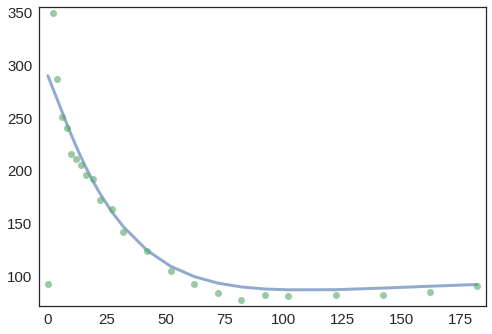

In [32]:
plot(results.G)
plot(df.glucose, style='o')

In [33]:
def mse(actual, model):
    return np.sum((model-actual)**2)

In [36]:
mse(df.glucose, results.G)

45851.05978514188

In [187]:
from scipy.optimize import leastsq

In [188]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

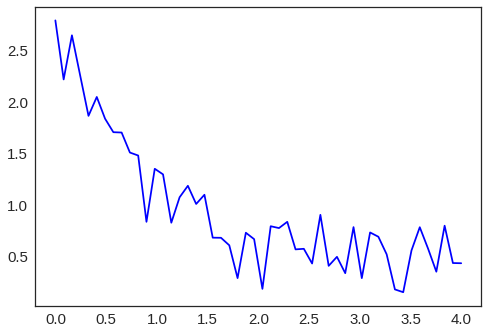

In [189]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

In [197]:
def err_func(params, actual):
    model = func(xdata, *params)
    error = model - actual
    return error

In [199]:
x0 = 2.5, 1.3, 0.5
err_func(x0, ydata)

array([ 0.20738271,  0.53001981, -0.12580895,  0.06346546,  0.27113618,
       -0.07738551, -0.01409466, -0.01572045, -0.13220286, -0.04518703,
       -0.11313563,  0.44478373, -0.14961879, -0.16554211,  0.24139526,
       -0.06312296, -0.22607759, -0.09515607, -0.22645387,  0.15382097,
        0.1215287 ,  0.16447193,  0.45656816, -0.00934507,  0.03129905,
        0.49516227, -0.13205804, -0.12991115, -0.20516745,  0.05008735,
        0.03289083,  0.16556757, -0.3174546 ,  0.17038844,  0.07497498,
        0.22744894, -0.22694747,  0.26395029, -0.1855107 , -0.14819786,
        0.01854289,  0.35665628,  0.38056876, -0.0287616 , -0.25734934,
       -0.05153906,  0.17103272, -0.27845741,  0.08316578,  0.08342417])

In [200]:
args = (ydata,)
popt, ier = leastsq(err_func, x0=x0, args=args)
popt

array([ 2.34024457,  1.14913816,  0.43942598])

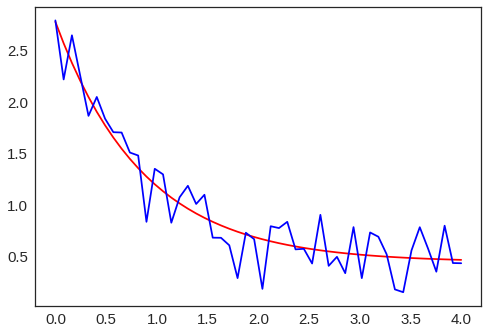

In [201]:
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')
plt.plot(xdata, ydata, 'b-', label='data')

In [41]:
popt

array([ 2.50162835,  1.33195541,  0.55934538])

In [133]:
k1 = 0.03
k2 = 0.02
k3 = 1e-05
G0 = 290

In [134]:
def make_system(G0, k1, k2, k3):
    init = State(G=G0, X=0)
    system = System(init=init, 
                    k1=k1, k2=k2, k3=k3,
                    Gb=Gb, Ib=Ib, I=I,
                    ts=df.index)
    return system

In [135]:
def min_func(ts, G0, k1, k2, k3):
    print(G0, k1, k2, k3)
    system = make_system(G0, k1, k2, k3)
    run_odeint(system, slope_func)
    return system.results.G

In [136]:
series = min_func(ts, G0, k1, k2, k3)
series

290 0.03 0.02 1e-05


time
0      290.000000
2      278.441946
4      267.246339
6      255.791154
8      244.385049
10     233.385689
12     222.875391
14     212.883104
16     203.432604
19     190.311106
22     178.430723
27     161.141293
32     146.627308
42     124.272257
52     109.125928
62      99.310554
72      93.102455
82      89.434359
92      87.498085
102     86.712650
122     86.844866
142     88.356758
162     90.136930
182     91.795663
Name: G, dtype: float64

In [137]:
params = [G0, k1, k2, k3]
params

[290, 0.03, 0.02, 1e-05]

In [138]:
popt, pcov = curve_fit(min_func, df.glucose.index, df.glucose.values, p0=params)

290.0 0.03 0.02 1e-05
290.0 0.03 0.02 1e-05
290.0 0.03 0.02 1e-05
290.000004321 0.03 0.02 1e-05
290.0 0.030000000447 0.02 1e-05
290.0 0.03 0.020000000298 1e-05
290.0 0.03 0.02 1.0000000149e-05
262.493673893 0.0201273809935 0.00245144666008 1.92369456889e-05
268.162650851 0.0274362051555 0.0133003595107 1.34043117011e-05
268.162654847 0.0274362051555 0.0133003595107 1.34043117011e-05
268.162650851 0.0274362055643 0.0133003595107 1.34043117011e-05
268.162650851 0.0274362051555 0.0133003597089 1.34043117011e-05
268.162650851 0.0274362051555 0.0133003595107 1.34043119009e-05
268.130426905 0.0267895723351 0.0133400852219 1.32669040366e-05
268.130430901 0.0267895723351 0.0133400852219 1.32669040366e-05
268.130426905 0.0267895727343 0.0133400852219 1.32669040366e-05
268.130426905 0.0267895723351 0.0133400854206 1.32669040366e-05
268.130426905 0.0267895723351 0.0133400852219 1.32669042343e-05
268.106028185 0.0267883857165 0.0133425246125 1.32677630015e-05
268.10603218 0.0267883857165 0.0133425

In [139]:
popt

array([  2.67821508e+02,   2.67309385e-02,   1.33515814e-02,
         1.32268293e-05])

In [151]:
def indices(G0, k1, k2, k3):
    return State(S_G=k1, S_I=k3/k2)

In [152]:
indices(*popt)

,value
S_G,0.026731
S_I,0.000991


In [154]:
system = make_system(*popt)
run_odeint(system, slope_func)

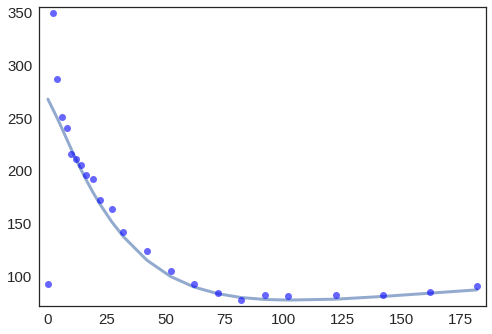

In [155]:
plot(system.results.G)
plot(df.glucose, style='bo')

In [184]:
def min_func(x, actual):
    print(x)
    system = make_system(*x)
    run_odeint(system, slope_func)
    error = system.results.G - actual
    #error /= actual
    return error[4:]

In [185]:
min_func(params, df.glucose)

[290, 0.03, 0.02, 1e-05]


time
8       4.385049
10     17.385689
12     11.875391
14      7.883104
16      7.432604
19     -1.688894
22      6.430723
27     -1.858707
32      4.627308
42      0.272257
52      4.125928
62      7.310554
72      9.102455
82     12.434359
92      5.498085
102     5.712650
122     4.844866
142     6.356758
162     5.136930
182     1.795663
dtype: float64

In [180]:
from scipy.optimize import leastsq

In [186]:
args = (df.glucose,)
popt, ier = leastsq(min_func, x0=params, args=args)
popt

[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000004e+02   3.00000000e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000004e-02   2.00000000e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000003e-02   1.00000000e-05]
[  2.90000000e+02   3.00000000e-02   2.00000000e-02   1.00000001e-05]
[  2.78224727e+02   2.85801825e-02   1.61589429e-02   1.19289840e-05]
[  2.78224731e+02   2.85801825e-02   1.61589429e-02   1.19289840e-05]
[  2.78224727e+02   2.85801829e-02   1.61589429e-02   1.19289840e-05]
[  2.78224727e+02   2.85801825e-02   1.61589432e-02   1.19289840e-05]
[  2.78224727e+02   2.85801825e-02   1.61589429e-02   1.19289842e-05]
[  2.71951893e+02   2.68943464e-02   1.28042303e-02   1.03928810e-05]
[  2.71951897e+02   2.68943464e-02   1.28042303e-02   1.03928810e-05]
[  2.71951893e+02   

array([  2.71894408e+02,   2.67752596e-02,   1.22393398e-02,
         1.07668838e-05])

In [182]:
system = make_system(*popt)
run_odeint(system, slope_func)

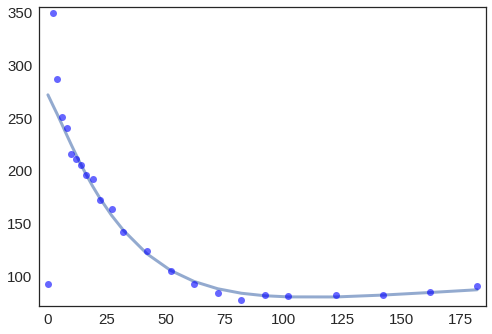

In [183]:
plot(system.results.G)
plot(df.glucose, style='bo')

In [176]:
indices(*x)

,value
S_G,0.026775
S_I,0.000880


**Exercise:**

In [ ]:
I0 = 363
k = 0.267
gamma = 0.0041
G_T = 83.7

In [ ]:
def make_system(I0, k, gamma, G_T):
    init = State(I=I0)
    system = System(init=init, k=k, gamma=gamma, G_T=G_T,
                    G_interp = interpolate(df.glucose),
                    t0=0, t_end=182)
    return system

In [ ]:
system = make_system(I0, k, gamma, G_T)
system

In [ ]:
def slope_func(state, t, system):
    I = state
    unpack(system)
    
    G = G_interp(t)
    if G > G_T:
        dIdt = gamma * (G - G_T) * (t - t0) - k * I
    else:
        dIdt = -k * I
    
    return dIdt

In [ ]:
slope_func(init, 0, system)

In [ ]:
def run_odeint(system, slope_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    slope_func: function that computes slopes
    """
    unpack(system)

    ts = df.index
    args = system,
    array = odeint(slope_func, init, ts, args)

    system.results= TimeFrame(array, columns=init.index, index=ts)

In [ ]:
run_odeint(system, slope_func)
system.results

In [ ]:
plot(system.results)
plot(df.insulin)

In [ ]:
def min_func(ts, I0, k, gamma, G_T):
    print(I0, k, gamma, G_T)
    system = make_system(I0, k, gamma, G_T)
    run_odeint(system, slope_func)
    return system.results.I

In [ ]:
min_func(ts, I0, k, gamma, G_T)

In [ ]:
params = [I0, k, gamma, G_T]
params

In [ ]:
popt, pcov = curve_fit(min_func, df.insulin.index, df.insulin.values, p0=params)

In [ ]:
I0, k, gamma, G_T = popt

In [ ]:
system = make_system(*popt)

In [ ]:
run_odeint(system, slope_func)

In [ ]:
plot(system.results)
plot(df.insulin)

In [ ]:
I_max = df.insulin.max()
Ib = df.insulin[0]
I_max, Ib

In [ ]:
Gb = df.glucose[0]
G0, Gb

In [ ]:
phi_1 = (I_max - Ib) / k / (G0 - Gb)
phi_1

In [ ]:
phi_2 = gamma * 1e4
phi_2